<h2>Random Forest, Decision Trees, Gradient Boosting using XGBoost/LightGBM/CatBoost, AdaBoost</h2>

<h3>Random Forest -- Ensemble method which handles mixed data types, feature importance, and is very robust</h3>

In [2]:
import pandas as pd

df = pd.read_csv("datasets/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
df['pass_all'] = (
    (df['math score'] >= 50) &
    (df['reading score'] >= 50) &
    (df['writing score'] >= 50)
).astype(int)

X = df.drop(['math score', 'reading score', 'writing score', 'pass_all'], axis=1)
y = df['pass_all']

X = pd.get_dummies(X, drop_first=True) # One hot encoding

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 12  26]
 [ 18 144]]
              precision    recall  f1-score   support

           0       0.40      0.32      0.35        38
           1       0.85      0.89      0.87       162

    accuracy                           0.78       200
   macro avg       0.62      0.60      0.61       200
weighted avg       0.76      0.78      0.77       200



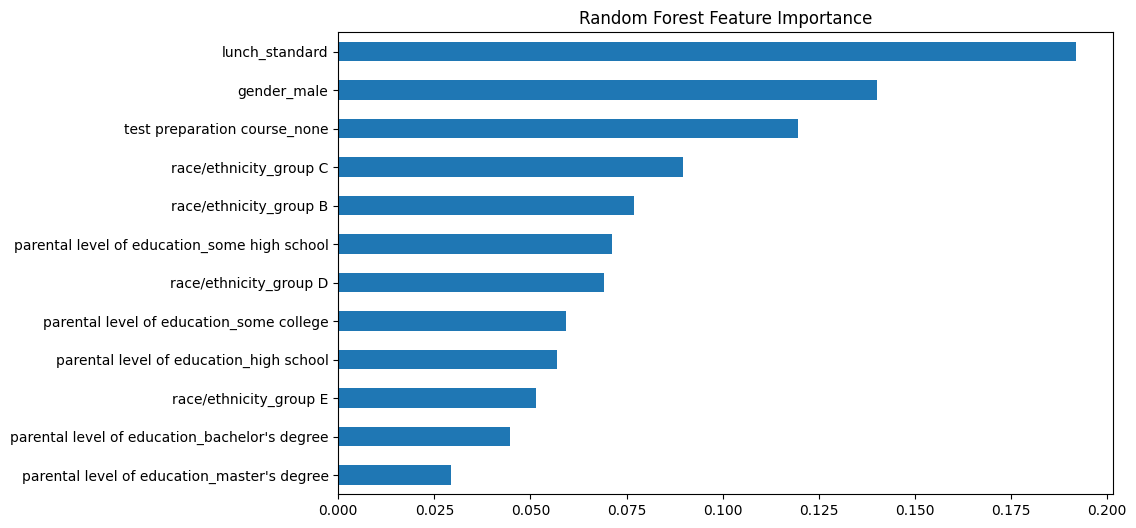

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Random Forest Feature Importance")
plt.show()

In [12]:
# Let's attempt to fix the weaknesses of struggling with class 0, i.e. failing students, low precision, and imbalance of passers vs failers that likely skews the model 
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # <-- THIS IS KEY
    random_state=42
)
rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)

In [13]:
print(confusion_matrix(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

[[ 14  24]
 [ 42 120]]
              precision    recall  f1-score   support

           0       0.25      0.37      0.30        38
           1       0.83      0.74      0.78       162

    accuracy                           0.67       200
   macro avg       0.54      0.55      0.54       200
weighted avg       0.72      0.67      0.69       200



In [15]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [17]:
# This can still be improved, and we can use SMOTE resampling, preprocessing technique used to address a class imbalance in a dataset

from imblearn.over_sampling import SMOTE

X_train = X_train.astype(int)
X_test = X_test.astype(int)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_res, y_train_res)

y_pred_smote = rf_smote.predict(X_test)

print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

[[ 21  17]
 [ 51 111]]
              precision    recall  f1-score   support

           0       0.29      0.55      0.38        38
           1       0.87      0.69      0.77       162

    accuracy                           0.66       200
   macro avg       0.58      0.62      0.57       200
weighted avg       0.76      0.66      0.69       200



<h3>Decision Trees</h3>

In [5]:
import pandas as pd

df = pd.read_csv('datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


(7032, 20)
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges       

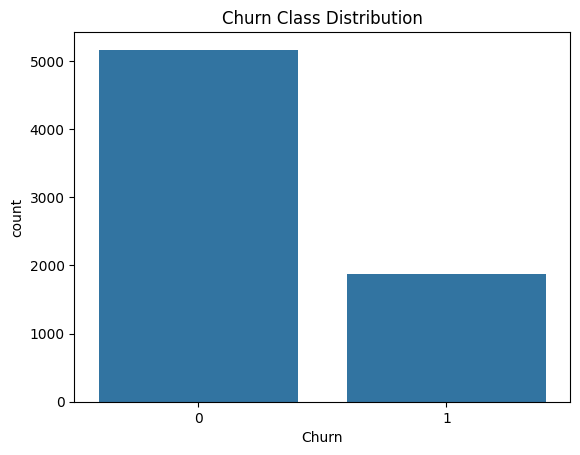

In [18]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())
df.describe()

import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=df, x='Churn')
plt.title("Churn Class Distribution")
plt.show()

In [6]:
print(df.columns.tolist())

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [7]:
df.drop(columns=['customerID'], inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.dropna(inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns='Churn').columns

df_encoded = pd.get_dummies(df, drop_first=True)

In [19]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train.value_counts())

After SMOTE: Churn
1    3872
0    3872
Name: count, dtype: int64


In [20]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [21]:
# from sklearn.metrics import classification_report, confusion_matrix 

y_pred_dt = dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

[[1015  276]
 [ 153  314]]
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1291
           1       0.53      0.67      0.59       467

    accuracy                           0.76      1758
   macro avg       0.70      0.73      0.71      1758
weighted avg       0.78      0.76      0.76      1758



<h3>Gradient Boosting using XGBoost/LightGBM/CatBoost/AdaBoost</h3>

In [14]:
!pip install xgboost lightgbm catboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 299.1 kB/s eta 0:00:00 kB/s eta 0:00:01:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 1.5 MB/s eta 0:00:00m eta 0:00:010:00:020m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 1.5 MB/s eta 0:00:00m eta 0:00:010:01:02

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)

from catboost import CatBoostClassifier

cat_features = list(cat_cols) # Use original df, not one-hot encoded

X_cb = df.drop(columns='Churn')
y_cb = df['Churn']

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, stratify=y_cb, random_state=42)

cb = CatBoostClassifier(verbose=0, random_state=42)
cb.fit(X_train_cb, y_train_cb, cat_features=cat_features)

from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

/home/jafar/.local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1402, number of negative: 3872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5274, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265832 -> initscore=-1.015871
[LightGBM] [Info] Start training from score -1.015871


/home/jafar/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

In [16]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

models = {
    'Decision Tree': dt,
    'AdaBoost': ada,
    'XGBoost': xgb,
    'LightGBM': lgb,
    'CatBoost': cb
}

for name, model in models.items():
    if name == 'CatBoost':
        preds = model.predict(X_test_cb)
    else:
        preds = model.predict(X_test)
    acc = accuracy_score(y_test if name != 'CatBoost' else y_test_cb, preds)
    f1 = f1_score(y_test if name != 'CatBoost' else y_test_cb, preds)
    print(f"{name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

Decision Tree: Accuracy = 0.7878, F1 Score = 0.5199
AdaBoost: Accuracy = 0.8043, F1 Score = 0.5981
XGBoost: Accuracy = 0.7696, F1 Score = 0.5350
LightGBM: Accuracy = 0.7907, F1 Score = 0.5731
CatBoost: Accuracy = 0.7975, F1 Score = 0.5752


<b>Conclusions:</b>

    CatBoost and AdaBoost are performing best
    
    XGBoost is slightly behind, likely due to how it handles categorical variables (which CatBoost natively excels at)
    
    LightGBM and Decision Tree give stable baselines, but are outperformed

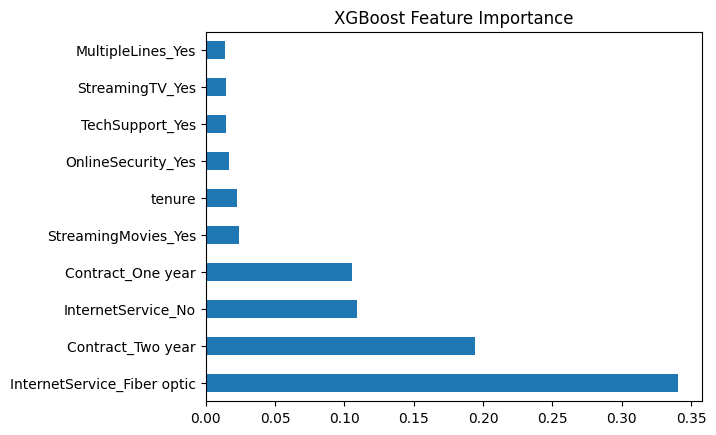

In [17]:
import matplotlib.pyplot as plt

xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)
xgb_importance.nlargest(10).plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.show()

InternetService_Fiber optic – heavy indicator of churn, likely due to higher cost

Contract_Two year – reduces churn (locked-in users)

InternetService_No – loyal non-internet users?

Contract_One year – moderate retention

StreamingMovies_Yes – weaker signal, but usage behavior matters

📌 Interpretation:

Contract type is a critical churn predictor

Fiber-optic users churn more — upselling or pricing issues?